# Weighted RNN for News-Text Classification

## Importing Required Libraries

In [0]:
import os
import sys
import pickle
import keras
import numpy as np
import pandas as pd
import numpy
import matplotlib as plt
%matplotlib inline

import gensim 
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts, get_tmpfile

from numpy import loadtxt
from keras.models import load_model
from keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation ,Permute ,SimpleRNN , Bidirectional ,TimeDistributed, Conv1D ,Activation, Flatten
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential
from keras import regularizers
from keras.utils import np_utils
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

# Final Classification Result as requested is given towards the end

## Loading Test/Train Data

In [0]:
# Use this to load the training and testing data files. If you want to see how these files were generated please refer 'Generator.ipynb'

# Loading Traning and Testing Data
#To read from pickled file
with open("train_data.p", "rb") as fp:   # Unpickling (Assuming file in same folder else please give complete path)
    train_data = pickle.load(fp)
with open("desired_train_data.p", "rb") as fp:   # Unpickling
    train_y = pickle.load(fp)

#To read from pickled file
with open("test_data.p", "rb") as fp:   # Unpickling
    test_data = pickle.load(fp)
with open("desired_test_data.p", "rb") as fp:   # Unpickling
    test_y = pickle.load(fp)

In [0]:
# Loading Model KeyedVectors and word2vec model
# Please refer to Generator.ipynb for model building code
#path = get_tmpfile('wordvectors1.kv')
wv = KeyedVectors.load("wordvectors1.kv", mmap='r')
# No of words in our vocabulary
len(wv.vocab)
#path_model = get_tmpfile('wordvectors1.model')
#model = gensim.models.Word2Vec.load("wordvectors1.model")

In [0]:
# Making required in-memory training and testing lists of size (no. of docs, 300 , 200)
# 200 is the size of our word2vec model

# Training
data_train = []
padd = [0]*200
for i in train_data:
    a=[]
    count=0
    for j in i:
        count+=1
        a.append(wv[j])
        if count==300:
            break
    if(len(a)<300):
        while(len(a)!=300):
              a.append(padd)
    data_train.append(a)

# Testing
data_test = []
padd = [0]*200
for i in test_data:
    a=[]
    count=0
    for j in i:
        count+=1
        a.append(wv[j])
        if count==300:
            break
    if(len(a)<300):
        while(len(a)!=300):
            a.append(padd)
    data_test.append(a)

In [0]:
# Finally

# To create required input for the Keras Model
truncate = len(data_train)-(len(data_train)%128)
data_train = data_train[:truncate]
train_y = train_y[:truncate]

truncate = len(data_test)-(len(data_test)%128)
data_test = data_test[:truncate]
test_y = test_y[:truncate]

# Debugging
'''
print(len(data_train)%128)
print(len(train_y)%128)
print(len(data_test)%128)
print(len(test_y)%128)
'''

data_train = np.array(data_train)
y_train = np.array(train_y)
data_test = np.array(data_test)
y_test = np.array(test_y)

assert(data_train.shape[0]==y_train.shape[0])
assert(data_test.shape[0]==y_test.shape[0])

In [0]:
print(data_train.shape, data_test.shape , y_train.shape, y_test.shape)

In [0]:
# Debugging # y_test is one hot encoded for 20 categories
for i in y_train:
    if list(i) == [0]*20:
        print('Wrong')

In [0]:
# Backup
'''
import copy
backup_data_train = copy.deepcopy(data_train)
backup_y_train = copy.deepcopy(y_train)
backup_data_test = copy.deepcopy(data_test)
backup_y_test = copy.deepcopy(y_test)
'''

In [0]:
# Shuffle two numpy arrays together
def shuffle_in_unison(a, b): # Inplace
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    return a,b

def shuffle_in_unison1(a,b): # Using Temp Extra Memory
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [0]:
# Final Shuffled Arrays
data_train,y_train = shuffle_in_unison1(data_train,y_train)
data_test, y_test = shuffle_in_unison1(data_test,y_test)

In [0]:
# We have training and testing data which can be fed to the network now

## Helper Functions

In [0]:
# Saving a keras model
from numpy import loadtxt
# model is name of the model to be save , file_name is file with which to save
def mysave(model,file_name): # in file_name include .h5
    model.save(file_name)

In [0]:
# loading a saved keras model
def myload(file_name): # in file_name include .h5
    # load model
    model = load_model(file_name)
    # summarize model.
    model.summary()
    return model

## MODELS

### SimpleRNN (Reference Model - I)

In [0]:
# Constants
batch_Size = 128
adam = keras.optimizers.Adam(lr=0.01)
early = EarlyStopping(monitor = 'val_categorical_accuracy', verbose=1, mode = 'max', patience = 3)

In [0]:
## Network architecture
#model name - modelrnn, history name - history_rnn
modelrnn = Sequential()
modelrnn.add(LSTM(128, input_shape=(300,200), dropout=0.2,recurrent_dropout=0.2,return_sequences = False))
modelrnn.add(Dense(128,activation='relu'))
#modelrnn.add(Dense(128,activation='relu'))
modelrnn.add(Dense(20,activation='softmax'))
modelrnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[keras.metrics.categorical_accuracy])
## Fit the model
history_rnn = modelrnn.fit(data_train, y_train, validation_split=0.01, epochs=10 ,batch_size=batch_Size)
modelrnn.summary()

In [0]:
# Saving the RNN model
mysave(modelnn,"RNN_final.h5")

### Bi-LSTM (Reference Model - II)

In [0]:
## Network architecture
#Model Name - modelnn, history name - history_bi
modelnn = Sequential()
modelnn.add(Bidirectional(LSTM(128, input_shape=(300,200), dropout=0.2,recurrent_dropout=0.2,return_sequences = False)))
modelnn.add(Dense(128,activation='relu'))
modelnn.add(Dense(20,activation='softmax'))
modelnn.compile(loss='categorical_crossentropy', optimizer=adam, metrics=[keras.metrics.categorical_accuracy])
## Fit the model
history_bi = modelnn.fit(data_train, y_train, validation_split=0.01, epochs=4 ,batch_size=batch_Size,callbacks= [early])
modelnn.summary()

In [0]:
# Saving the BiLSTM model
mysave(modelnn,"Bi_LSTM_final.h5")

### W-RNN Model

In [0]:
## Network architecture
#Model name - modelnn_LSTM, history name - history_LSTM
modelnn_LSTM = Sequential()
modelnn_LSTM.add((LSTM(128, input_shape=(300,200), dropout=0.2,recurrent_dropout=0.2,return_sequences = True )))  # Creates individual word vectors
modelnn_LSTM.add(Permute((2,1)))
modelnn_LSTM.add(TimeDistributed(Dense(1)))
modelnn_LSTM.add(Flatten()) # Final Document Vector
# Classification
modelnn_LSTM.add(Dense(128,activation='relu'))
modelnn_LSTM.add(Dense(20,activation='softmax',kernel_initializer='he_normal',kernel_regularizer=regularizers.l1_l2(l1=0.01,l2=0.01)))

modelnn_LSTM.compile(loss='categorical_crossentropy',optimizer=adam, metrics=[keras.metrics.categorical_accuracy])
modelnn_LSTM.summary()
history_LSTM = modelnn_LSTM.fit(data_train,y_train, validation_split=0.05,epochs=100 ,batch_size=batch_Size, callbacks= [early])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 300, 128)          168448    
_________________________________________________________________
permute_3 (Permute)          (None, 128, 300)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 128, 1)            301       
_________________________________________________________________
flatten_2 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_7 (Dense)              (None, 20)                2580      
Total params: 187,841
Trainable params: 187,841
Non-trainable params: 0
________________________________________________

In [0]:
# Saving the WRNN model
mysave(modelnn_LSTM,"WRNN_Final.h5")

## Model Evaluation

In [0]:
# This function will give the confusion matrix, precision, recall, f1 measure for the given model name as argument
def getresults(model,y_test,batch):
    y_pred = model.predict(data_test,batch_size=batch)
    print(metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print(metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), digits=3))

In [0]:
#Model name is specified on top of each model in comments
# Output shown for WRNN
getresults(modelnn_LSTM,y_test,128)     # WRNN

# Uncomment to get appropriate model results
#getresults(modelrnn,y_test,128)        # SimpleLSTM
#getresults(modelnn,y_test,128)         # BiLSTM
#getresults(modelnn_BiLSTM,y_test,128)  # W-BiLSTM

Accuracy: 0.894792
[[ 75   1   0   0   0   0   0   0   1   0   0   0   1   1   1   1   0   1
    1  17]
 [  1  81   2   2   3   4   1   0   0   0   0   0   1   0   1   1   0   1
    1   0]
 [  0   5  49   5   4   2   2   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   1   3  79  10   0   7   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   2  86   1  10   0   0   0   0   0   0   1   0   0   0   0
    0   0]
 [  0   1   0   0   0  99   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   2   1   0  96   1   0   0   0   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   4  92   1   0   0   0   1   2   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0  98   1   1   0   0   0   0   0   0   0
    0   0]
 [  0   1   0   0   0   0   2   0   0  95   2   0   0   0   0   0   0   0
    0   0]
 [  0   0   0   0   0   0   0   0   0   1 100   0   0   0   0   0   0   0
    0   0]
 [  0   1   0   0   0   0   0   0   0   0   0 

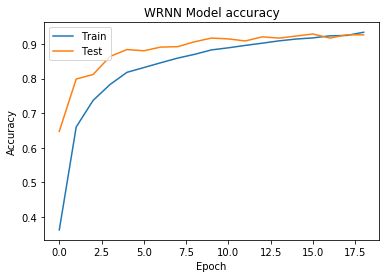

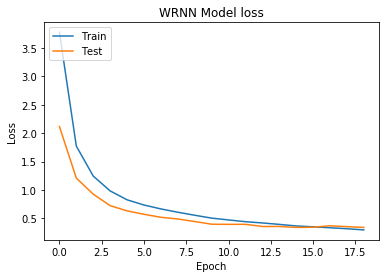

In [0]:
#Initialize history with correct name of the history (given on top of each model in comments)
history = history_LSTM
# Plot training & validation accuracy values

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('WRNN Model accuracy') #change name accordingly
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('WRNN Model loss') #change name accordingly
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
from keras.utils import plot_model
plot_model(modelnn_LSTM, to_file='model.png' , show_shapes=True)

## Classification Result of 25 Documents

In [0]:
Categories = {0:'alt.atheism',1:'comp.graphics',2:'comp.os.ms-windows.misc',3:'comp.sys.ibm.pc.hardware',4:'comp.sys.mac.hardware',5:'comp.windows.x'
,6:'misc.forsale',7:'rec.autos',8:'rec.motorcycles',9:'rec.sport.baseball',10:'rec.sport.hockey',11:'sci.crypt',12:'sci.electronics'
,13:'sci.med',14:'sci.space',15:'soc.religion.christian',16:'talk.politics.guns',17:'talk.politics.mideast',18:'talk.politics.misc'
,19:'talk.religion.misc'}

In [0]:
No_of_Samples = 25
Results = modelnn_LSTM.predict(data_test[:No_of_Samples])
Predictions=[]
for i in range(No_of_Samples):
    k=[]
    k.append( Categories.get(Results.argmax(axis=1)[i])) 
    k.append(Categories.get(y_test.argmax(axis=1)[i]))
    if(k[0]==k[1]):
        k.append('Correct')
    else:
        k.append('InCorrect')
    Predictions.append(k.copy())
df = pd.DataFrame(Predictions,columns=['Predicted','Actual','Status'])
df
# Since some categories are almost inter-related such categories have a more chance of incorrect output. This can be seen from the confusion matrix as well. 